In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response', 'volcano-plots')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)
    
def output_path(basename):
    return os.path.join(OUTPUT_DIRECTORY, basename)

In [3]:
import importlib
import helpers
importlib.reload(helpers)
from helpers import *

In [4]:
from snapanalysis.models.ptm_response.main import FDR_THRESHOLD_RESPONSE, FC_THRESHOLD_RESPONSE
from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER

In [5]:
palette_ptms = {
    'h2az': '#584A87',
    'me1': '#BBE1BB',
    'me2': '#9FBA7D',
    'me3': '#6F9979',
    'm5c': '#85B3B2',
    'ac': '#40678E'
}

palette = {
   'H2A.Z': palette_ptms['h2az'],
   'DNA Methylation': palette_ptms['m5c'],
}
for predictor in PREDICTOR_ORDER:
    
    if predictor.endswith('ac'):
        palette[predictor] = palette_ptms['ac']
    elif predictor[-3:] in ['me1', 'me2', 'me3']:
        palette[predictor] = palette_ptms[predictor[-3:]]


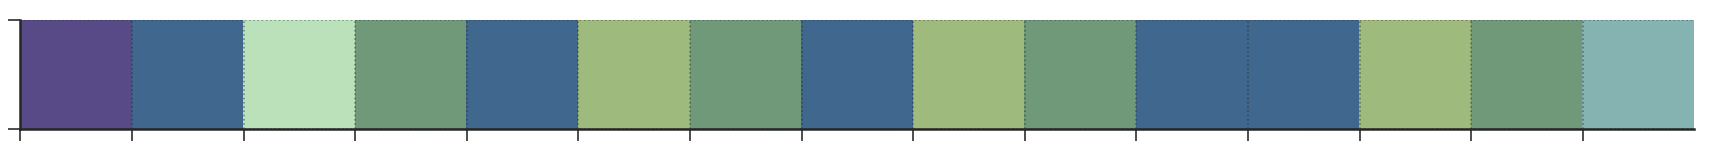

In [6]:
sns.palplot([palette[p] for p in PREDICTOR_ORDER])

# All volcanos

In [7]:
import r_helpers
importlib.reload(r_helpers)
from r_helpers import *

/usr/local/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:69: UserWarning: This was designed againt ggplot2 version 3.1.0 but you have 3.3.0
  'have %s' % (TARGET_VERSION, ggplot2.__version__))


First, all volcanos

In [8]:
from matplotlib.colors import to_hex

with r_plot_to_pdf(output_path('all_volcanos_large.pdf'),
                   width=10, height=10):

    for predictor in PREDICTOR_ORDER:
        plot_volcano_with_r(load_limma_data(predictor), 
                            title=predictor,
                            label_only_large_fc=True,
                            max_labels=None)



# Specific subgroups

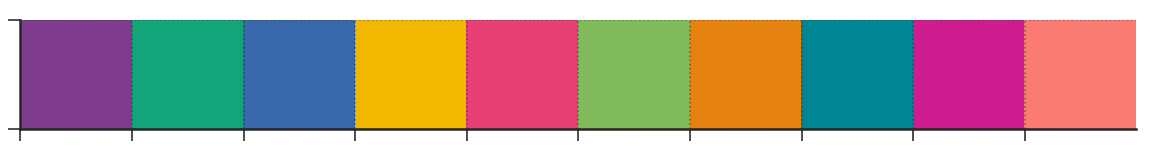

In [9]:
import palettable

cartocolors = dict(zip(
    ['Bold_purple', 
     'Bold_green', 
     'Bold_blue',
     'Bold_yellow',
     'Bold_pink',
     'Bold_lime_green',
     'Bold_orange',
     'Bold_petrol',
     'Bold_magenta',
     'Bold_rose'],
    palettable.cartocolors.qualitative.Bold_10.hex_colors
))
sns.palplot(cartocolors.values())
    

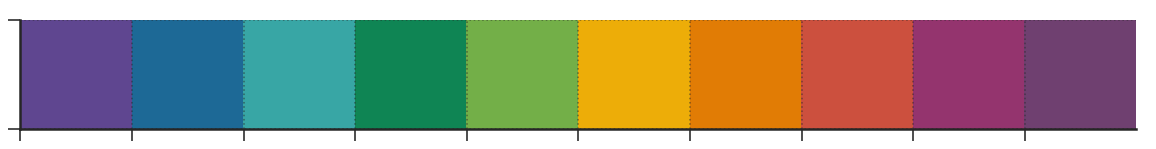

In [10]:
 sns.palplot(palettable.cartocolors.qualitative.Prism_10.hex_colors)

# H3K4me1 vs H3K4me3

There's a clear difference between H3K4me1 and H3K4me3.
Before we look into this further, let's have a look into H3K4me1 signal got diluted with H3K27me3 nucleosome.

In [11]:
data_full = load_limma_data('H3K4me1')
data_dropout = load_limma_data('H3K4me1', 'H3K27me3')

df_comp = pd.DataFrame({'full': data_full['significant'], 
                        'dropout': data_dropout['significant']}).fillna(False)

in_full_but_not_dropout = df_comp[(df_comp['full']) & (~df_comp['dropout'])].index
in_dropout_but_not_full = df_comp[(~df_comp['full']) & (df_comp['dropout'])].index

dropout_differences = {}
for k in in_full_but_not_dropout:
    dropout_differences[k] = 'Lost'

for k in in_dropout_but_not_full:
    dropout_differences[k] = 'Gained'


dropout_palette = {
    'Lost': cartocolors['Bold_pink'], 
    'Gained': cartocolors['Bold_blue'],
}

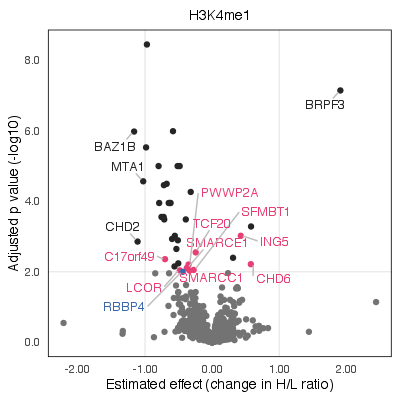

In [12]:
plot_volcano_with_r_inline_and_pdf(output_path('H3K4me1-dropout-effect-full.pdf'),
                                   data_full,
                                   title='H3K4me1',
                                   special_labels=dropout_differences,
                                   special_palette=dropout_palette,
                                   label_only_large_fc=True,
                                   max_labels=20)

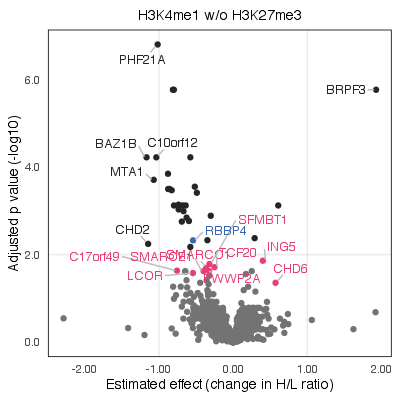

In [13]:
plot_volcano_with_r_inline_and_pdf(output_path('H3K4me1-dropout-effect-full-wo-K27me3.pdf'),
                                   data_dropout, 
                                   special_labels=dropout_differences,
                                   special_palette=dropout_palette,
                                   title='H3K4me1 w/o H3K27me3', 
                                   label_only_large_fc=True,
                                   max_labels=20)

In [14]:
df_comp.loc[df_comp['dropout'], 'full'].value_counts()

True     29
False     1
Name: full, dtype: int64

It looks like that removing H3K27me3 only causes some proteins to be lost from the list due to the drop in p-value that is associated with removing a replicate. So I don't think it's the effect of losing this modification

In [15]:
highlights = {}

skip = {
    'HDAC1', 'RBBP4', 'RBBP7', 'HDAC2', # Common among many complexes.
}

for (complex_, complex_label) in [
    ('TFIID', 'TFIID'),
    (['HBO1', 'MOZ/MORF'], 'MOZ/MORF/HBO1'),
    ('PRC2.1', 'PRC2.1'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label

palette = {}
palette['TFIID'] = cartocolors['Bold_petrol']
palette['MOZ/MORF/HBO1'] = cartocolors['Bold_orange']
palette['PRC2.1'] = '#8EB46B'


In [16]:
for ptm in ['H3K4me3', 'H3K4me1']:
    print(ptm)
    print(predictor_sorted_uri(ptm))

H3K4me3
http://ife-snap-data/proteins?pdorder=H02,H13,H21,H15,H11,H14,H22,H40,H41&showsimilar=false&noclusterproteins=true
H3K4me1
http://ife-snap-data/proteins?pdorder=H05,H03,H06,H13,H16,H30,H31,H15,H09&showsimilar=false&noclusterproteins=true


TAF11 not in data index..
TAF13 not in data index..
TAF2 (2) not in data index..
TAF4B not in data index..
TBP/TBPL2 not in data index..
JADE2 not in data index..
KAT6A not in data index..
KAT7 (2) not in data index..
PHF1 not in data index..
PHF19 not in data index..


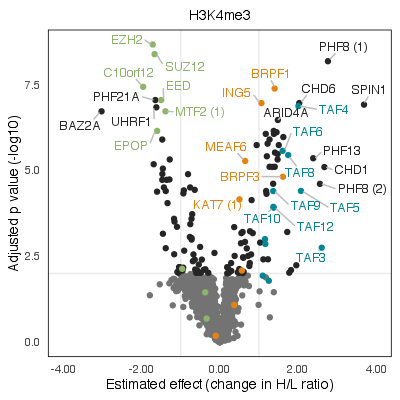

TAF11 not in data index..
TAF13 not in data index..
TAF2 (2) not in data index..
TAF4B not in data index..
TBP/TBPL2 not in data index..
JADE2 not in data index..
KAT6A not in data index..
KAT7 (2) not in data index..
PHF1 not in data index..
PHF19 not in data index..
TAF11 not in data index..
TAF13 not in data index..
TAF2 (2) not in data index..
TAF4B not in data index..
TBP/TBPL2 not in data index..
JADE2 not in data index..
KAT6A not in data index..
KAT7 (2) not in data index..


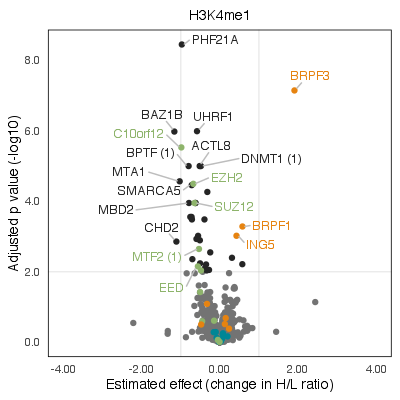

TAF11 not in data index..
TAF13 not in data index..
TAF2 (2) not in data index..
TAF4B not in data index..
TBP/TBPL2 not in data index..
JADE2 not in data index..
KAT6A not in data index..
KAT7 (2) not in data index..


In [17]:
skip_labels = {
    # Remove some labels from crowded areas where they're not important
    'H3K4me3': {'TAF1', 'ING4', 'LCOR', 'TAF9B'},
    'H3K4me1': {
        'LCOR', 
    }
}

# Fine adjustments
nudges = {
    'H3K4me3': {
        'BRPF3': (-1.0, 0),
        'TAF4': (0.5, 0),
        'PHF21A': (-0.5, 0),
        'KAT7 (1)': (-0.2, 0.0),
        'MTF2 (1)': (0.2, 0.2),
        'EED': (0.2, 0),
        'EPOP': (-0.5, -0.2),
        'UHRF1': (0, -0.5),
        'TAF5': (0.2, -0.2),
    },
    'H3K4me1': {
        'EED': (-0.5, -0.5),
        'MTF2 (1)': (-0.5, 0),
        'ING5': (0.5, 0)
    }
}

for ptm in ['H3K4me3', 'H3K4me1']:
    plot_volcano_with_r_inline_and_pdf(
        output_path(f'{ptm}-coloured.pdf'),
        load_limma_data(ptm), 
        width=4,
        height=4,
        special_labels=highlights,
        special_palette=palette,
        title=ptm,
        label_size=3,
        label_only_large_fc=False,
        special_labels_mode='significant',
        xlim=(-4, 4),
        max_labels=10,
        skip_labels=skip_labels.get(ptm),
        nudges=nudges.get(ptm))

# H2A.Z 

Here the key is to show NSL, INO80 and SRCAP complexes

In [18]:
df = load_limma_data('H2A.Z').query('significant == True')

for direction in ["Up", 'Down']:
    for effect_size in ['Large', 'Small']:
        mask = pd.Series(True, index=df.index)
        if effect_size == 'Large':
            mask &= df['significant_and_large_fc']
        else:
            mask &= ~df['significant_and_large_fc']
            
        if direction == 'Up':
            mask &= df['logFC'] > 0
        else:
            mask &= df['logFC'] < 0
            
        
        subdf = df[mask]
        if not subdf.empty:
            url = predictor_sorted_uri('H2A.Z', 
                                       sorted(subdf.index), 
                                       extra_pds=['H38', 'H44'])
            print(f'{effect_size} {direction}: {url}')
            
# for x in df
# predictor_sorted_uri('H2A.Z')

Large Up: http://ife-snap-data/proteins?pdorder=H36,H26,H37,H43,H45,H38,H44&k=p:ACTR5&k=p:BEND3&k=p:DIDO1&k=p:E4F1&k=p:INO80B&k=p:KANSL1&k=p:KANSL2&k=p:KANSL3&k=p:MCRS1&k=p:MTA1&k=p:NFRKB&k=p:PHF20&k=p:PWWP2A&k=p:TFPT&k=p:YY1&k=p:ZNF367&k=p:ZNF839&showsimilar=false&noclusterproteins=true
Small Up: http://ife-snap-data/proteins?pdorder=H36,H26,H37,H43,H45,H38,H44&k=p:ASH2L&k=p:ASXL2&k=p:BAP1&k=p:BBX&k=p:BLM&k=p:CASZ1&k=p:CDYL&k=p:CUX1%20%281%29&k=p:DPY30&k=p:EHMT2&k=p:ELF4&k=p:FOXC1&k=p:GTF3C1&k=p:GTF3C2&k=p:GTF3C4&k=p:H1FX&k=p:HCFC1%20%281%29&k=p:HCFC2&k=p:INTS1&k=p:INTS13&k=p:INTS14&k=p:INTS2&k=p:KLF16&k=p:KMT2A&k=p:KMT2B&k=p:KMT2C&k=p:KMT2D&k=p:LMNB2&k=p:MEN1&k=p:NCOA6&k=p:NFIB&k=p:NSD1&k=p:OGT&k=p:PAX6&k=p:PAXIP1&k=p:PRR12&k=p:RBBP5&k=p:RBPJ&k=p:RFWD3&k=p:RMI1&k=p:RMI2&k=p:RNF40&k=p:RPA1&k=p:RPA2&k=p:RPA3&k=p:SP1&k=p:SPEN&k=p:TOP3A&k=p:WIZ%20%281%29&k=p:ZBTB40&k=p:ZMYM3&k=p:ZNF148&k=p:ZNF319&k=p:ZNF644&showsimilar=false&noclusterproteins=true
Large Down: http://ife-snap-data/protein

In [19]:
highlights = {}

skip = {
    'MCRS1', # INO80/NSL
    
    # INO80/SRCAP
    'RUVBL1', 
    'RUVBL2',
    'ACTL6A',
}


for (complex_, complex_label) in [
    ('NSL', 'NSL'),
    ('SRCAP', 'SRCAP'),
    ('INO80', 'INO80'),
]:
    for protein in members_of(complex_):
        if protein in skip:
            continue
        
        if protein in highlights:
            raise Exception(f'Duplicate mapping for {protein}')
        
        highlights[protein] = complex_label

# Readd skipped labels
for protein in ['MCRS1']:
    if protein in highlights:
        raise Exception(f'Duplicate mapping for {protein}')
        
    highlights[protein] = 'INO80/NSL'
    
for protein in ['RUVBL1', 'RUVBL2', 'ACTL6A']:
    if protein in highlights:
        raise Exception(f'Duplicate mapping for {protein}')
        
    highlights[protein] = 'INO80/SRCAP'
    
for protein in ['TOP2A', 'TOP2B (1)', 'TOP2B (2)']:
    if protein in highlights:
        raise Exception(f'Duplicate mapping for {protein}')
        
    highlights[protein] = 'TOP2A/B'
    
    
# sns.palplot([cartocolors['Bold_blue'], cartocolors['Bold_purple'], 'black'])
#sns.palplot([cartocolors['Bold_yellow'], cartocolors['Bold_pink'], '#BE5846'])


palette = {
    'NSL': cartocolors['Bold_yellow'],
    'SRCAP': cartocolors['Bold_blue'],
    'INO80': cartocolors['Bold_pink'],
    'INO80/NSL':cartocolors['Bold_orange'],
    'INO80/SRCAP': cartocolors['Bold_purple'],
    'TOP2A/B': '#000000',
}


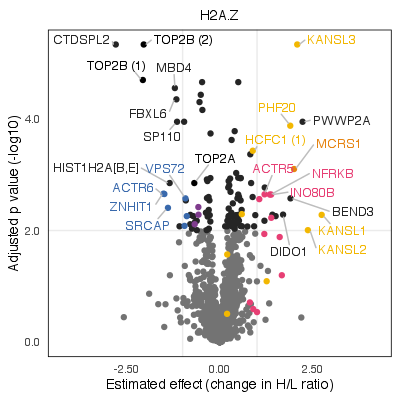

In [20]:
nudges = {
    'H2A.Z': {
        # Right side
        'PWWP2A': (0.5, 0),
        'PHF20': (-0.25, 0.25),
        'MCRS1': (0.75, 0.5),
        
        'DIDO1': (0.0, -0.5),
        'KANSL1': (0.5, -0.25),
        'KANSL2': (0.25, -0.25),
        
        'NFRKB': (1.0, 0.0),
        'BEND3': (1.0, -0.25),
        'INO80B': (2.0, 0.5),
        'ACTR5': (-0.5, 0.1),
                
        # Left side
        'ZNHIT1': (-0.5, -.1),
        'ACTR6': (0, -.1),
        'VPS72': (-0.2, 0.5),
        'HIST1H2A[B,E]/HIST3H2A': (-0.7, 0.0),
        
        'TOP2A': (0.5, 0.4),
    }
}

skip_labels = {
    'H2A.Z': {
        # Shared between INO80 and SRCAP
        'RUVBL1', 'RUVBL2', 'ACTL6A',
        # Overcrowded, no new information
        'OGT', 'YY1', 'TFPT',
        'YEATS4', 'DMAP1',
        
        # 
    },
}

plot_volcano_with_r_inline_and_pdf(
        output_path('H2AZ-coloured.pdf'),
        load_limma_data('H2A.Z'), 
        special_labels=highlights,
        special_palette=palette,
        title='H2A.Z',
        label_size=3,
        label_only_large_fc=False,
        special_labels_mode='significant',
        xlim=(-4.2, 4.2),
        nudges=nudges.get('H2A.Z'),
        skip_labels=skip_labels.get('H2A.Z'),
        max_labels=8)

Let's plot nice general plots for other pulldowns too

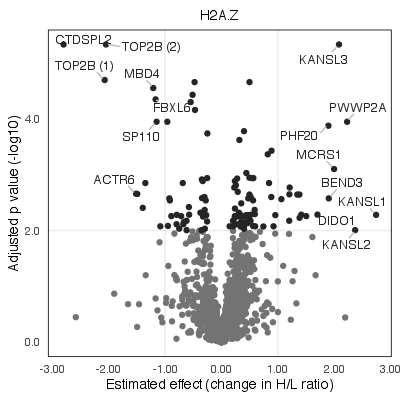

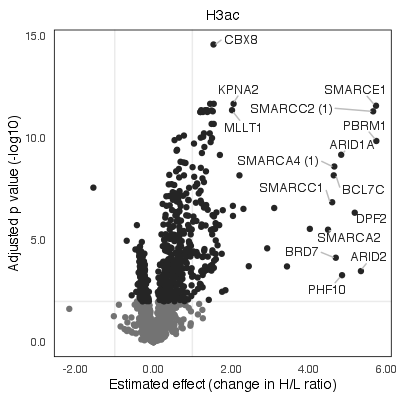

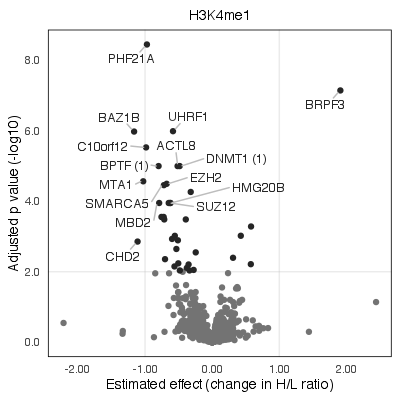

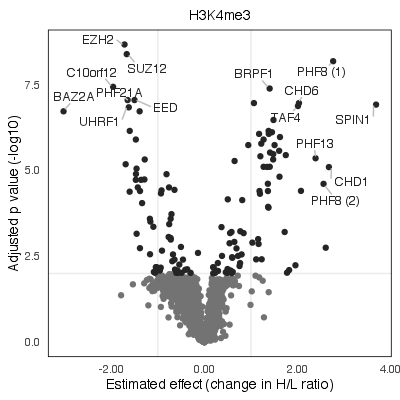

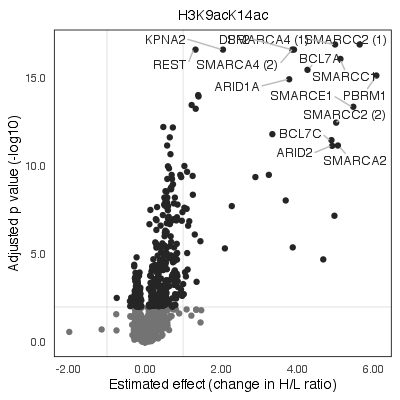

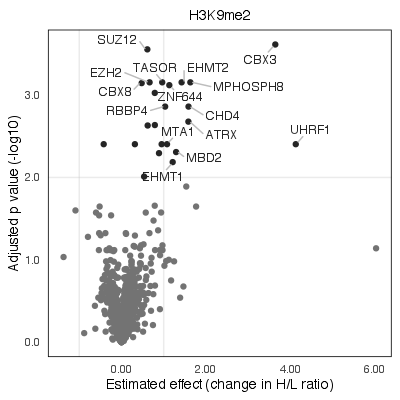

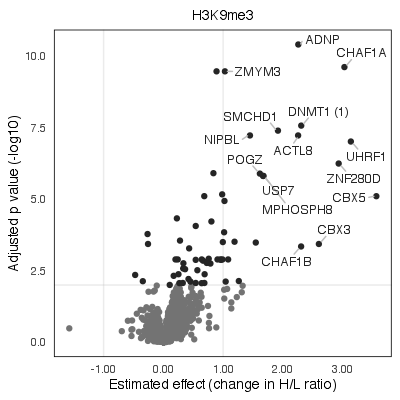

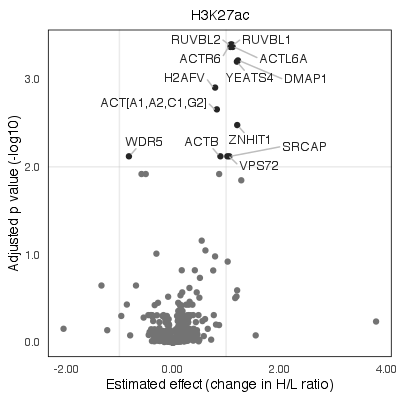

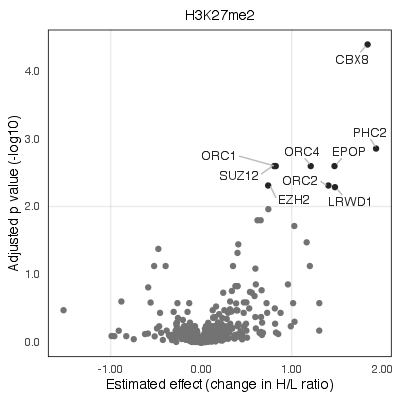

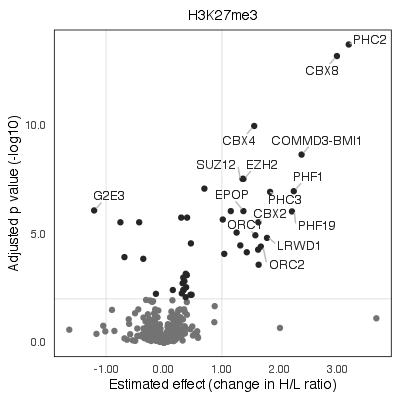

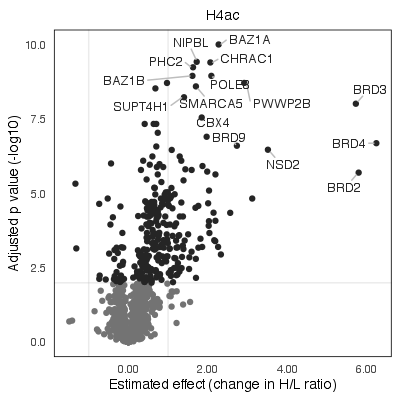

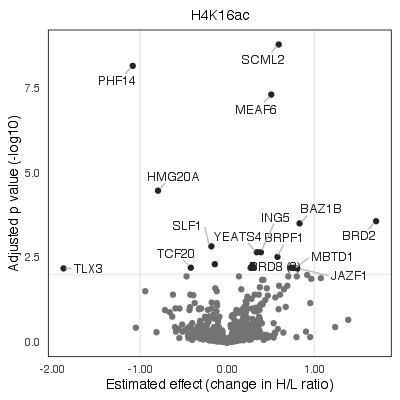

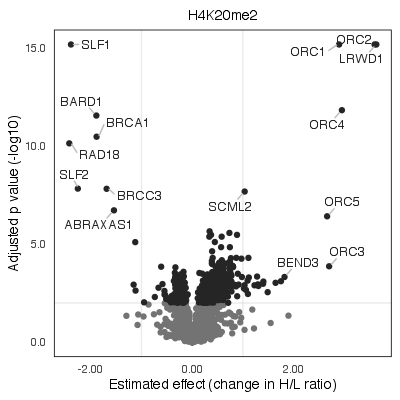

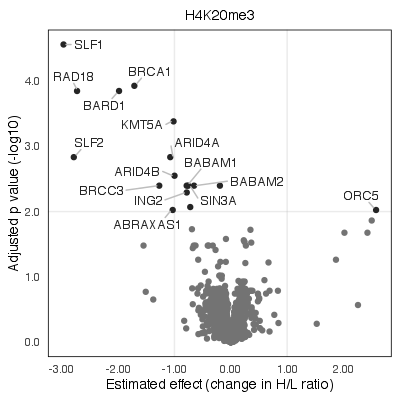

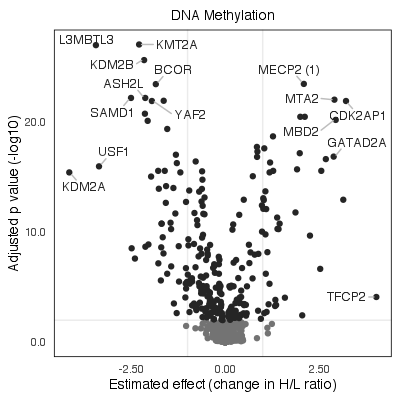

In [21]:
# Some plots need help to make them barely legible
nudges = {
    'H3K9acK14ac': {
        'SMARCA4 (1)': (-2.0, 0),
        'SMARCA4 (2)': (-2.0, -0.5),
        'KPNA2': (-1.0, 0.5),
    },
    'DNA Methylation': {
        'KMT2A': (1.0, 0),
    },
    'H3K27me2': {
        'ORC1': (-0.5, 0),
    },
    'H4ac': {
        'BAZ1B': (-0.5, 0),
    }
}

for ptm in PREDICTOR_ORDER:
#     if ptm not in nudges:
#         continue
        
    plot_volcano_with_r_inline_and_pdf(
        output_path(f'{ptm}.pdf'),
        load_limma_data(ptm), 
        width=4,
        height=4,
        special_labels={},
        special_palette={},
        title=ptm,
        label_size=3,
        label_only_large_fc=False,
        special_labels_mode='significant',
#         xlim=(-4, 4),
        max_labels=15,
        nudges=nudges.get(ptm)
    )
        
    